In [17]:
import networkx as nx
import numpy as np
from dataclasses import dataclass, field
import pandas as pd
import json
from plotnine import ggplot, aes, geom_smooth, geom_point, xlab, ylab

# Helper functions

In [18]:
@dataclass
class ResultSet:
    """
    Helper class to keep all results from a single experiment together
    """
    
    all_trails: np.array
    seed: np.array
    nuclei: np.array
    stations: np.array
    map_with_stations: np.array
    start_pos: np.array
    all_points: np.array = field(init=False)

    def __post_init__(self):
        points = self.nuclei.reshape(-1, 2)
        points = points[~np.all(points == 0, axis=1)]  # Remove zero points
        self.all_points = np.vstack([points, self.stations])

    def __str__(self):
        return f"Experiment with start pos {self.start_pos}, seed {self.seed}"

In [19]:
def calculate_network_cost(G, path_edges):
    """
    Calculates the cost of the total network
    """
    total_cost = 0.0
    for edge in path_edges:
        if G.has_edge(edge[0], edge[1]):
            total_cost += G[edge[0]][edge[1]]['weight']
    return total_cost

def calculate_mean_travel_time(G):
    """
    Calculates the mean travel time on the network
    """
    return G.size(weight='weight') / G.size()

def calculate_network_vulnerability(G, ref_travel_time):
    """
    Calculates the mean vulnerability on the network.
    If the graph becomes disconnected after an edge is removed,
    the vulnerability is then the weight of that edge.
    """
    vulnerabilities = []
    for e in G.edges():
        # Create a copy of the graph to avoid modifying the original
        G_copy = G.copy()
        G_copy.remove_edge(*e)
        mean_time = calculate_mean_travel_time(G_copy)
        if nx.is_connected(G_copy):
            vuln = np.abs(ref_travel_time - mean_time)
        else:
            vuln = G[e[0]][e[1]]['weight']
        vulnerabilities.append(vuln)
    return np.mean(vulnerabilities)

# Processing NS data

In [30]:
# Load datasets
ns_nodes = pd.read_csv('../distance-calculations/nodes.csv')
ns_edges = pd.read_csv('../distance-calculations/edges.csv')
station_coordinate_location_data = pd.read_csv('../distance-calculations/stations_of_interest.csv')
station_image_location_data = pd.read_csv('../distance-calculations/stations_in_output_json.csv')

# We need the conversion factor from coordinate space to image space
# we can use a least-squares approximation

joined_data = station_coordinate_location_data.join(station_image_location_data.set_index('code'), on='code')
coord_space_data = joined_data[['lat', 'lng']].to_numpy()
iamge_space_data = joined_data[['img_x', 'img_y']].to_numpy()

A, _, _, _ = np.linalg.lstsq(coord_space_data, iamge_space_data)

# Now, we can convert all stations to image space and use the same distance metric
img_space_df = pd.DataFrame(ns_nodes[['lat', 'lng']].to_numpy() @ A, columns=['img_x', 'img_y'])
ns_nodes_combined = pd.concat([ns_nodes.reset_index(drop = True), img_space_df], axis=1)

In [28]:
# First, we load the full NS graph
ns_graph = nx.Graph()

for _, edge in ns_edges.iterrows():
    from_node = ns_nodes_combined.query(f"name=='{edge['from']}'")[['img_x', 'img_y']].to_numpy()
    to_node = ns_nodes_combined.query(f"name=='{edge['to']}'")[['img_x', 'img_y']].to_numpy()

    dist = np.linalg.norm(from_node - to_node)
    ns_graph.add_edge(edge['from'], edge['to'], weight=dist)

In [27]:
# Then, we prune the edges that do not connect any stations in our final graph
# by taking the shortest path between all stations
# and only including edges in those paths
pruned_ns_graph = nx.Graph()

for _, s in station_coordinate_location_data.iterrows():
    source = s['code']
    for _, t in station_coordinate_location_data.iterrows():
        target = t['code']
        if source == target: continue
        try:
            length, path = nx.single_source_dijkstra(ns_graph, source=source, target=target, weight='weight')
            path_edges = list(zip(path, path[1:]))
            pruned_ns_graph.add_weighted_edges_from([(a, b, ns_graph[a][b]['weight']) for (a, b) in path_edges])
        except nx.NetworkXNoPath:
            continue

In [29]:
# Comparison of the total ns graph and the pruned ns graph
ns_total_cost = ns_graph.size('weight')
ns_mean_travel_time = ns_total_cost / len(station_coordinate_location_data) # Use number of nodes of interest, not total number of nodes
ns_network_vulnerability = calculate_network_vulnerability(ns_graph, ns_mean_travel_time)
ns_is_connected = nx.is_connected(ns_graph)

print("Full:")
print(f"Total cost of the network: {ns_total_cost:.2f}")
print(f"Mean travel time of the network: {ns_mean_travel_time:.2f}")
print(f"Network vulnerability (mean increase in travel time with one edge removed): {ns_network_vulnerability:.2f}")
print(f"Network is {"connected" if ns_is_connected else "not connected"}")

ns_total_cost = pruned_ns_graph.size('weight')
ns_mean_travel_time = ns_total_cost / len(station_coordinate_location_data) # Use number of nodes of interest, not total number of nodes
ns_network_vulnerability = calculate_network_vulnerability(pruned_ns_graph, ns_mean_travel_time)
ns_is_connected = nx.is_connected(pruned_ns_graph)

print("Pruned:")
print(f"Total cost of the network: {ns_total_cost:.2f}")
print(f"Mean travel time of the network: {ns_mean_travel_time:.2f}")
print(f"Network vulnerability (mean increase in travel time with one edge removed): {ns_network_vulnerability:.2f}")
print(f"Network is {"connected" if ns_is_connected else "not connected"}")

Full:
Total cost of the network: 6151.27
Mean travel time of the network: 180.92
Network vulnerability (mean increase in travel time with one edge removed): 135.14
Network is connected
Pruned:
Total cost of the network: 5004.32
Mean travel time of the network: 147.19
Network vulnerability (mean increase in travel time with one edge removed): 124.64
Network is connected


# Load and process data frames

In [26]:
proximities = range(1, 6)

different_starts = pd.DataFrame()
for proximity in proximities:
    df = pd.read_csv('../experiment_outputs_different_starts/results.csv')
    different_starts = pd.concat([different_starts, df], ignore_index=True, sort=False)
different_starts = different_starts.drop('Unnamed: 0', axis=1) # Drop old index column

same_starts = pd.DataFrame()
for proximity in proximities:
    df = pd.read_csv('../experiment_outputs_same_starts/results.csv')
    same_starts = pd.concat([same_starts, df], ignore_index=True, sort=False)
same_starts = same_starts.drop('Unnamed: 0', axis=1)

In [14]:
different_starts

,proximity,start_pos_x,start_pos_y,seed,total_cost,mean_travel_time,vulnerability,is_connected
0,1,444,601,6,2044.451127,85.372858,85.372858,False
1,2,444,601,6,4608.422106,109.924907,109.924907,False
2,3,444,601,6,6837.059559,129.952181,0.824733,True
3,4,444,601,6,9076.977256,148.611947,0.767377,True
4,5,444,601,6,11838.755194,164.744093,0.607708,True
...,...,...,...,...,...,...,...,...
745,1,692,468,15,2064.639278,86.026637,86.026637,False
746,2,692,468,15,4475.087944,110.848539,110.848539,False
747,3,692,468,15,6777.946524,129.425287,0.827261,True
748,4,692,468,15,9223.147838,147.934375,0.747297,True


In [15]:
same_starts

,proximity,start_pos_x,start_pos_y,seed,total_cost,mean_travel_time,vulnerability,is_connected
0,1,482,413,6,2034.273407,84.761392,84.761392,False
1,2,482,413,6,4456.276161,110.328607,110.328607,False
2,3,482,413,6,6642.131017,129.239963,0.829914,True
3,4,482,413,6,9181.373762,148.119183,0.772579,True
4,5,482,413,6,12355.016245,163.713011,0.589980,True
...,...,...,...,...,...,...,...,...
745,1,482,413,15,2062.427602,85.960191,85.960191,False
746,2,482,413,15,4425.856490,110.916061,110.916061,False
747,3,482,413,15,6766.698885,130.217586,2.125712,True
748,4,482,413,15,9810.164579,149.206370,0.752395,True


## Processing different starts

In [16]:
max_cost_different_starts = different_starts['total_cost'].max()
max_travel_time_different_starts = different_starts['mean_travel_time'].max()
max_vulnerability_different_starts = different_starts['vulnerability'].max()

different_starts = different_starts.assign(
    norm_cost = lambda df: df['total_cost'] / max_cost_different_starts
).assign(
    norm_travel_time = lambda df: df['mean_travel_time'] / max_travel_time_different_starts
).assign(
    norm_vulnerability = lambda df: df['vulnerability'] / max_vulnerability_different_starts
)

means_per_proximity_different_starts = different_starts.groupby('proximity', as_index=False).mean()[['proximity', 'norm_cost', 'norm_travel_time', 'norm_vulnerability']]

ns_different_starts = pd.DataFrame({
    'norm_cost': [ns_total_cost / max_cost_different_starts],
    'norm_travel_time':  [ns_mean_travel_time / max_travel_time_different_starts],
    'norm_vulnerability': [ns_network_vulnerability / max_vulnerability_different_starts]
})

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


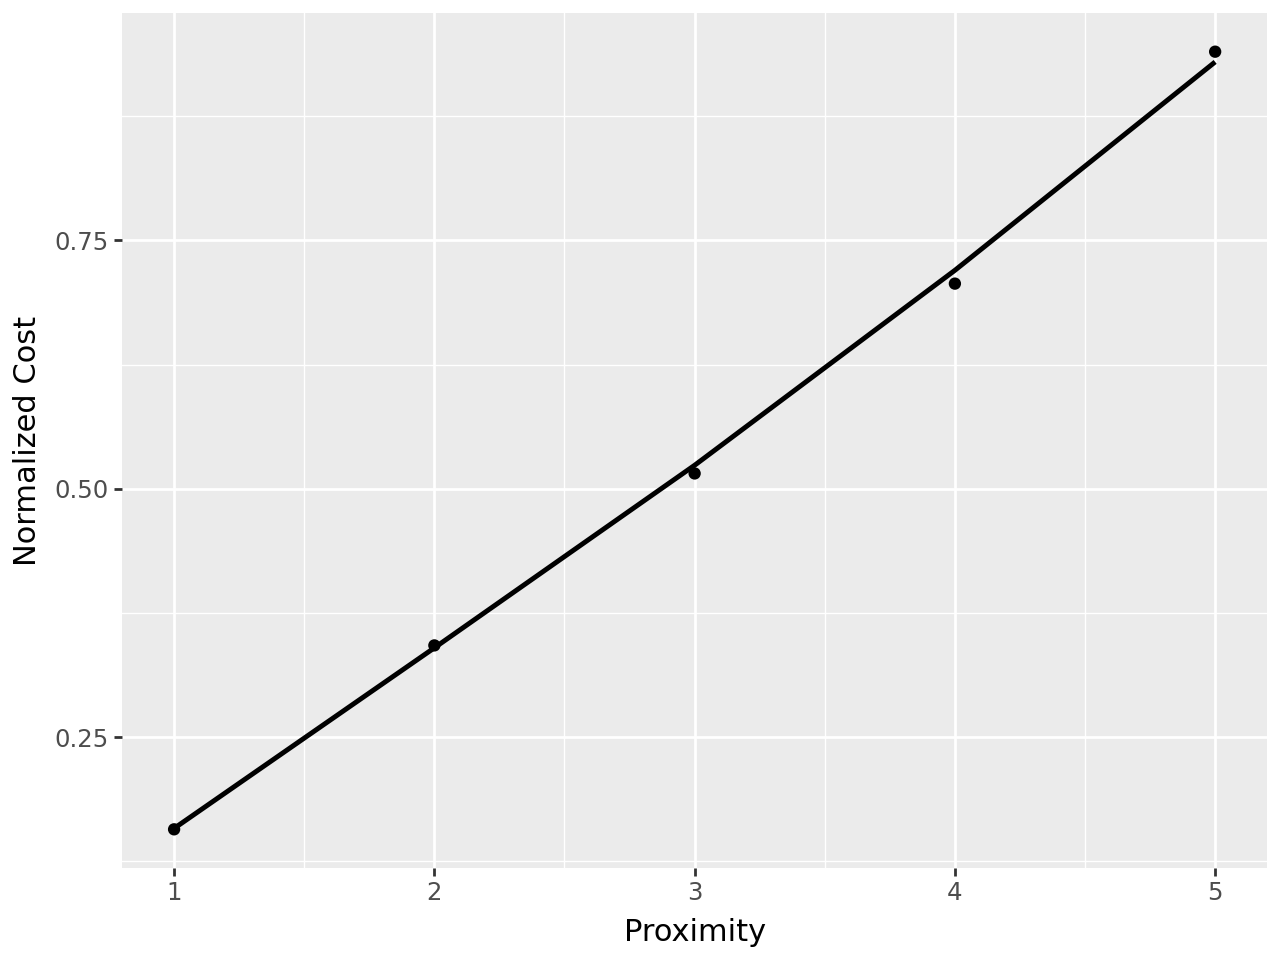

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_proximity_norm_cost.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [22]:
p =(
    ggplot(different_starts) + 
    aes(x='proximity', y='norm_cost') + 
    geom_point(data=means_per_proximity_different_starts) + 
    geom_smooth() +
    xlab("Proximity") +
    ylab("Normalized Cost")
)

p.show()
p.save("different_starts_proximity_norm_cost.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


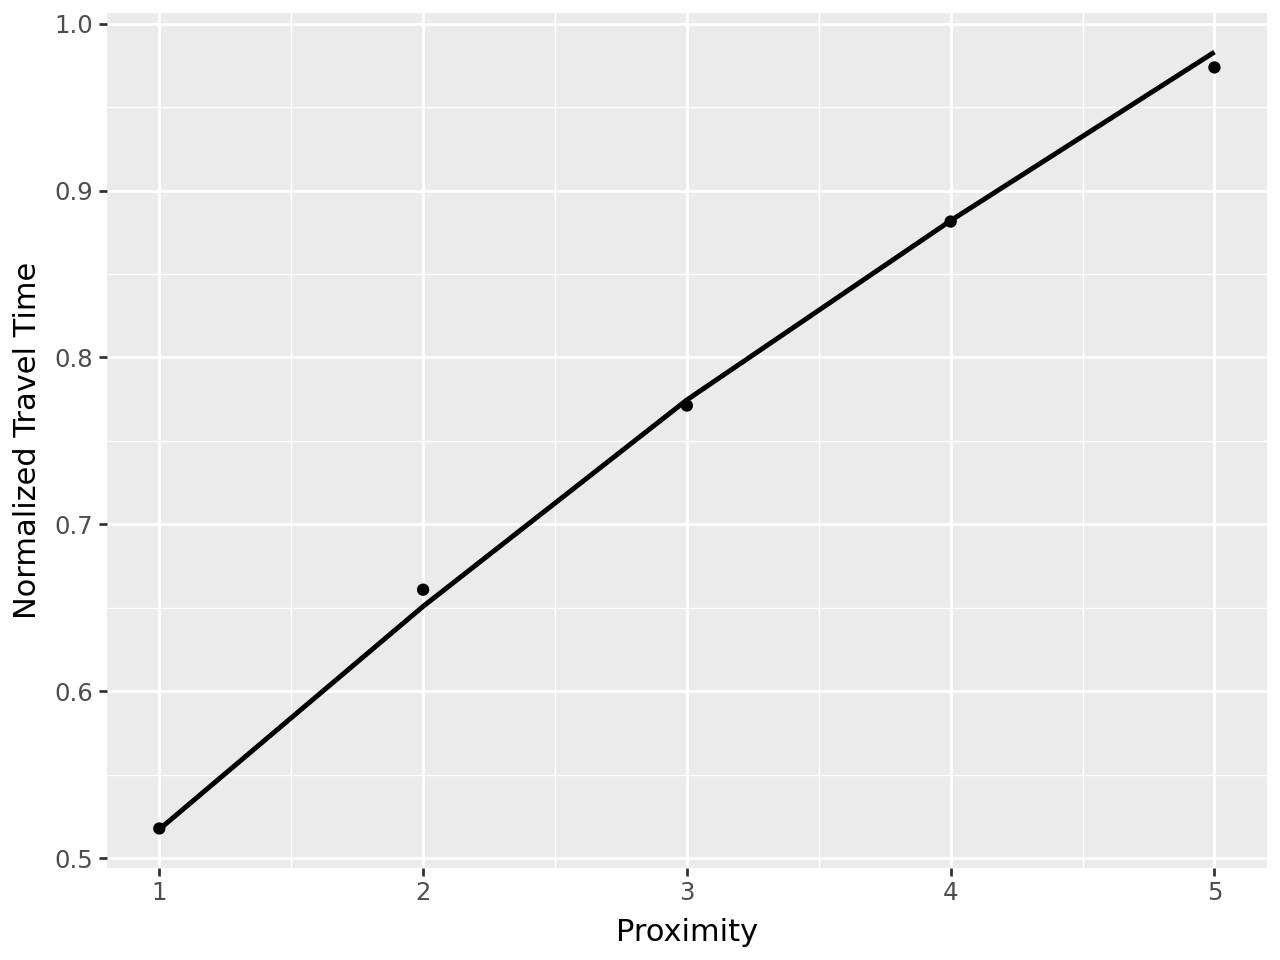

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_proximity_norm_travel_time.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [23]:
p= (
    ggplot(different_starts) + 
    aes(x='proximity', y='norm_travel_time') + 
    geom_point(data=means_per_proximity_different_starts) + 
    geom_smooth() +
    xlab("Proximity") +
    ylab("Normalized Travel Time")
)

p.show()
p.save("different_starts_proximity_norm_travel_time.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


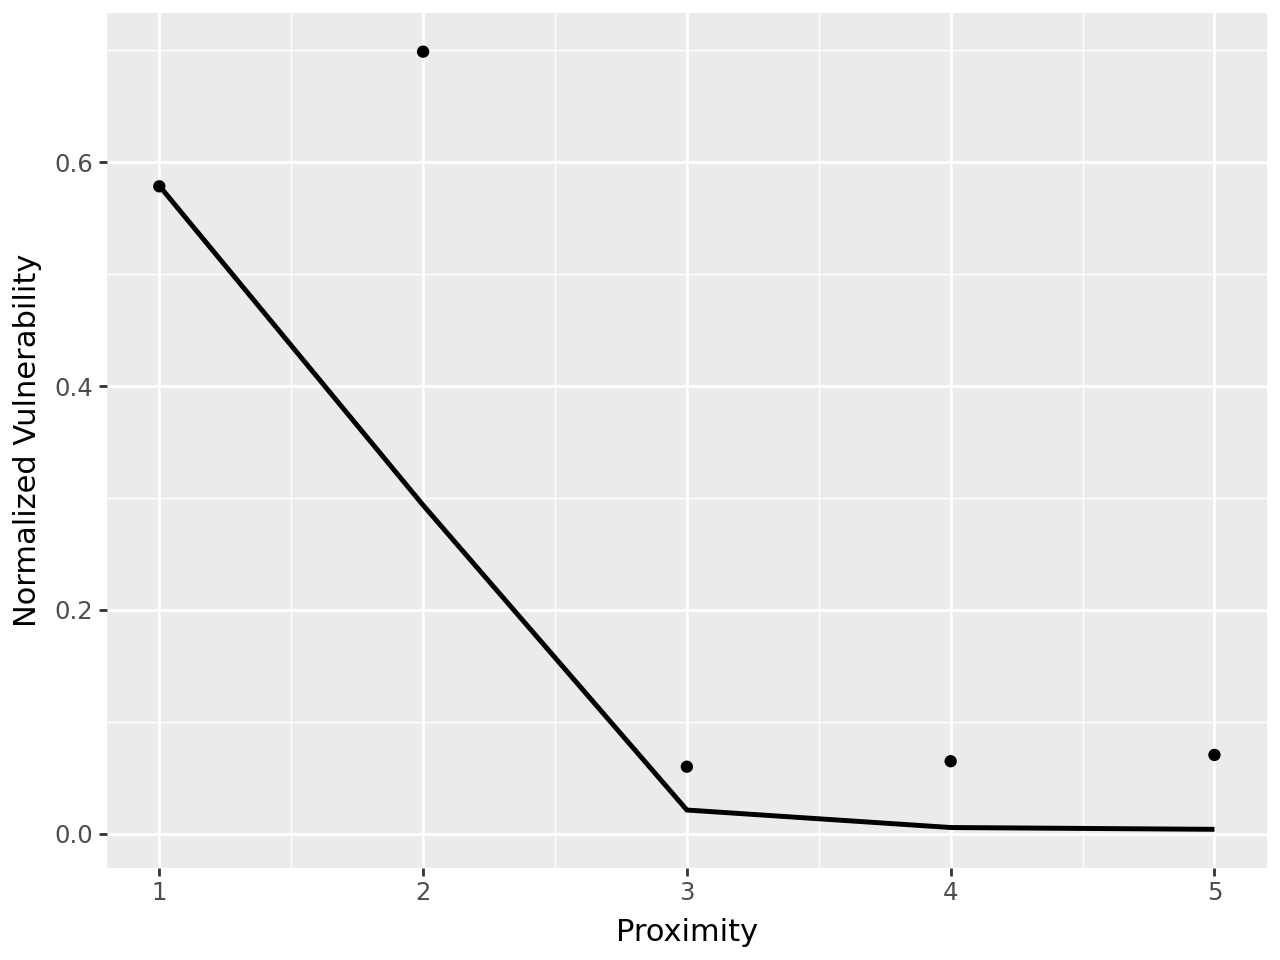

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_proximity_norm_vulnerability.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [24]:
p = (
    ggplot(different_starts) + 
    aes(x='proximity', y='norm_vulnerability') + 
    geom_point(data=means_per_proximity_different_starts) + 
    geom_smooth() +
    xlab("Proximity") +
    ylab("Normalized Vulnerability")
)

p.show()
p.save("different_starts_proximity_norm_vulnerability.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


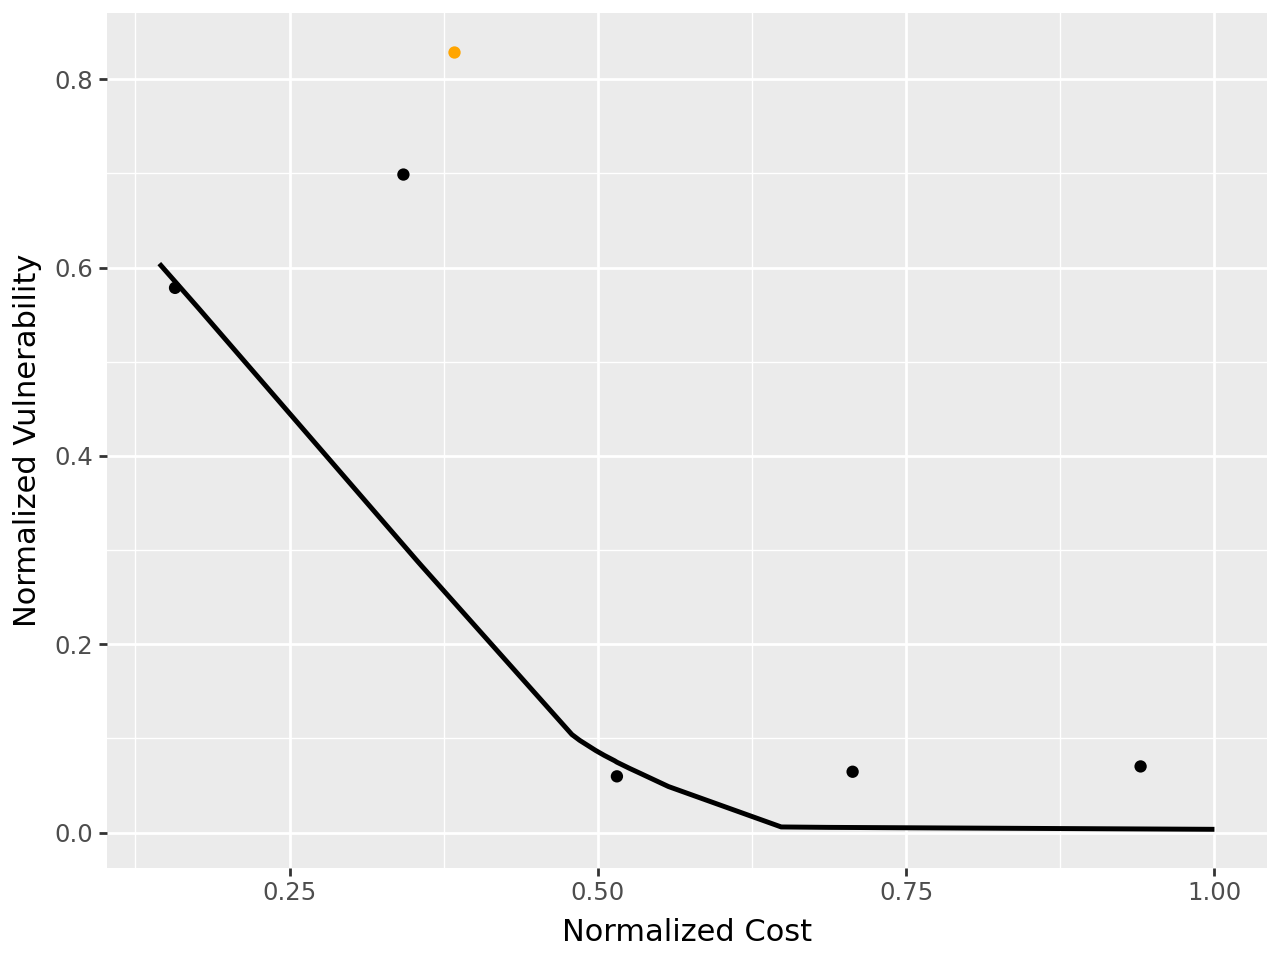

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_norm_cost_norm_vulnerability.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [25]:
p = (
    ggplot(different_starts) + 
    aes(x='norm_cost', y='norm_vulnerability') + 
    geom_point(data=means_per_proximity_different_starts) + 
    geom_smooth() +
    geom_point(data=ns_different_starts, color='orange') +
    xlab("Normalized Cost") +
    ylab("Normalized Vulnerability")
)

p.show()
p.save("different_starts_norm_cost_norm_vulnerability.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


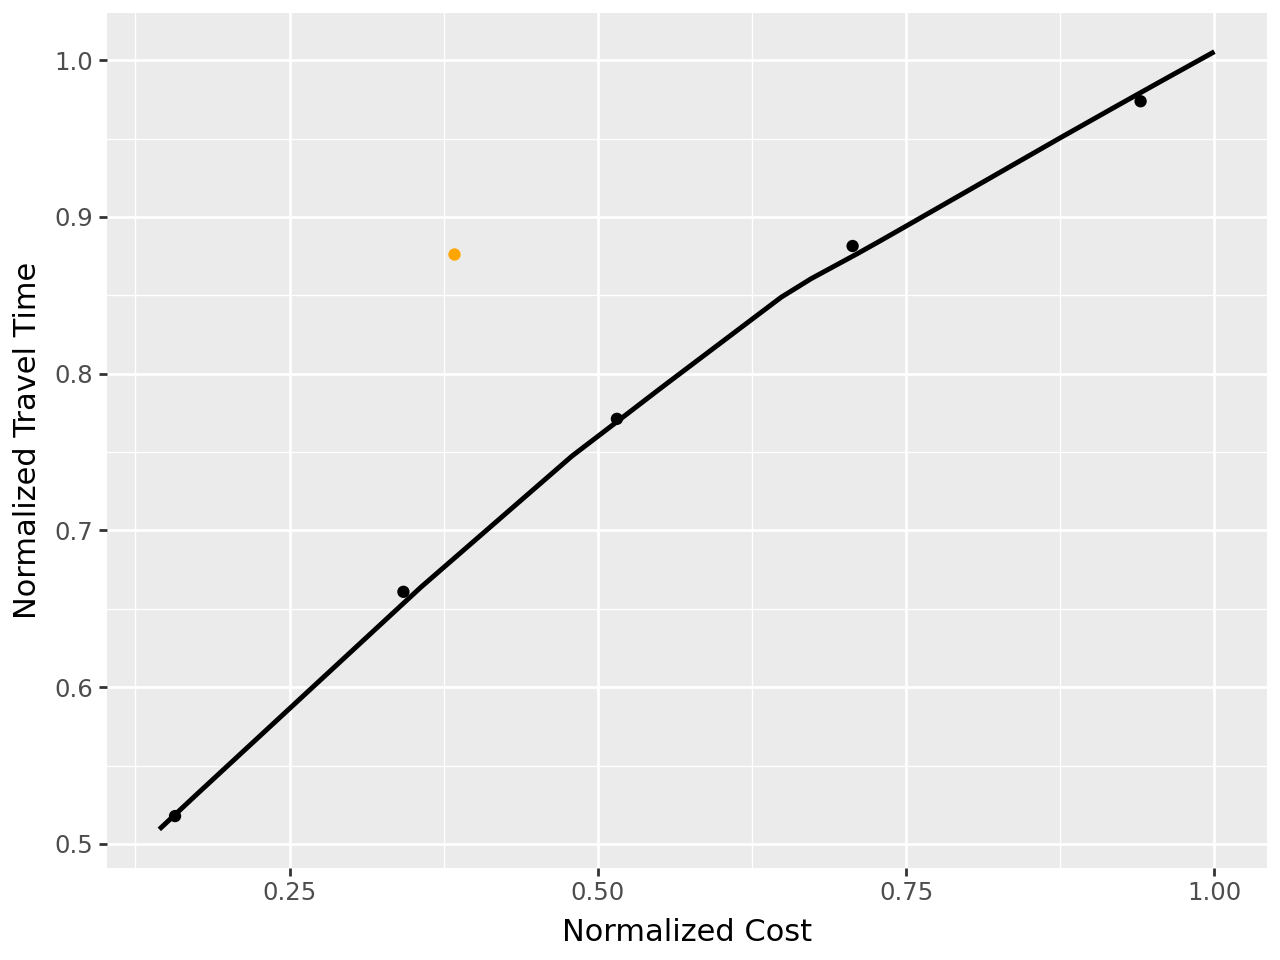

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_norm_cost_norm_travel_time.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [26]:
p = (
    ggplot(different_starts) + 
    aes(x='norm_cost', y='norm_travel_time') + 
    geom_point(data=means_per_proximity_different_starts) + 
    geom_smooth() +
    geom_point(data=ns_different_starts, color='orange') +
    xlab("Normalized Cost") +
    ylab("Normalized Travel Time")
)

p.show()
p.save("different_starts_norm_cost_norm_travel_time.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


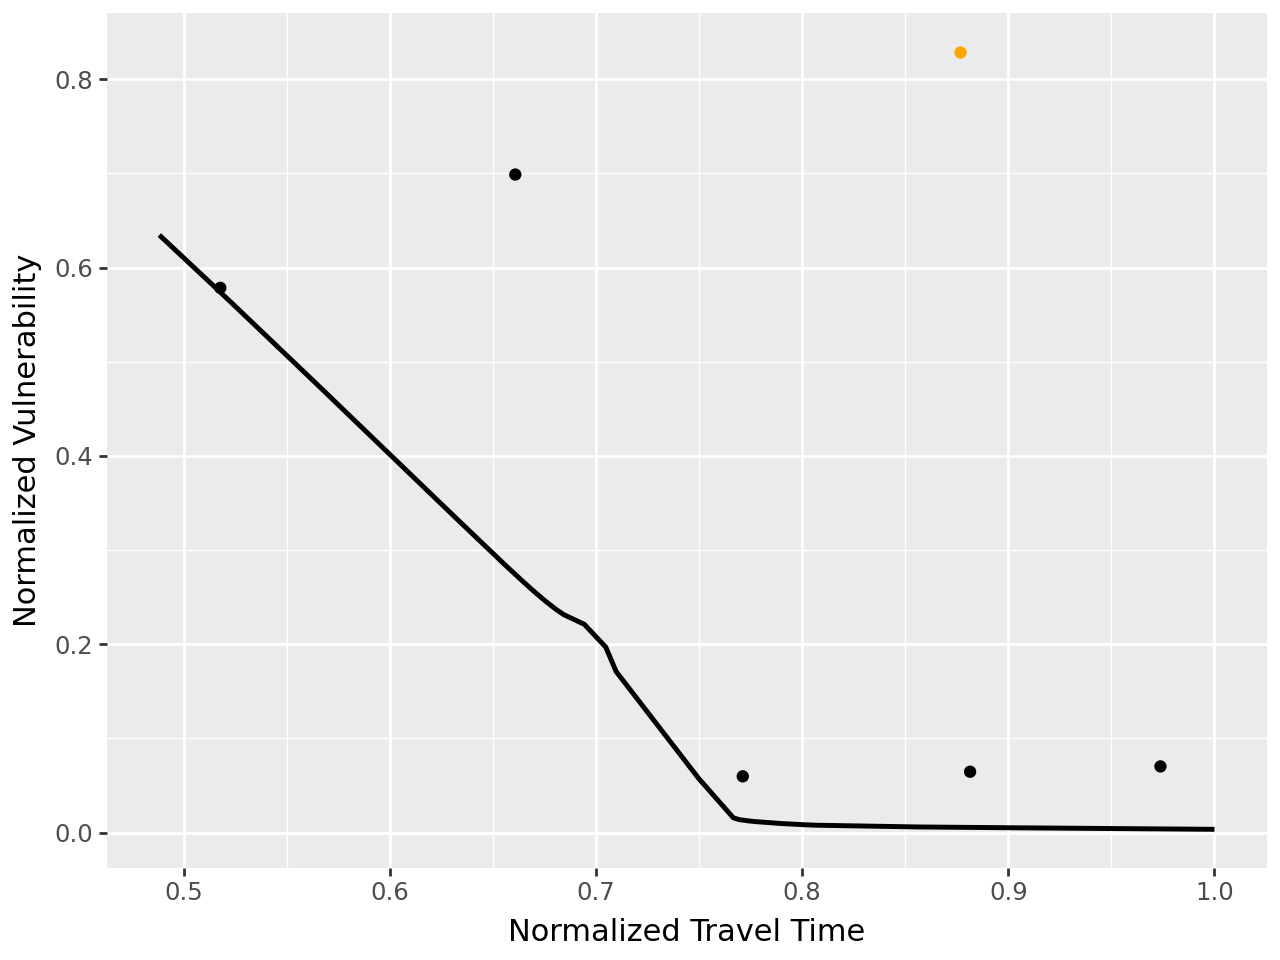

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: different_starts_norm_travel_time_norm_vulnerability.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [27]:
p = (
    ggplot(different_starts) + 
    aes(x='norm_travel_time', y='norm_vulnerability') + 
    geom_point(data=means_per_proximity_different_starts) + 
    geom_smooth() +
    geom_point(data=ns_different_starts, color='orange') +
    xlab("Normalized Travel Time") +
    ylab("Normalized Vulnerability")
)

p.show()
p.save("different_starts_norm_travel_time_norm_vulnerability.png")

## Processing same start

In [28]:
max_cost_same_starts = same_starts['total_cost'].max()
max_travel_time_same_starts = same_starts['mean_travel_time'].max()
max_vulnerability_same_starts = same_starts['vulnerability'].max()

same_starts = same_starts.assign(
    norm_cost = lambda df: df['total_cost'] / max_cost_same_starts,
).assign(
    norm_travel_time = lambda df: df['mean_travel_time'] / max_travel_time_same_starts
).assign(
    norm_vulnerability = lambda df: df['vulnerability'] / max_vulnerability_same_starts
)

means_per_proximity_same_starts = same_starts.groupby('proximity', as_index=False).mean()[['proximity', 'norm_cost', 'norm_travel_time', 'norm_vulnerability']]

ns_same_starts = pd.DataFrame({
    'norm_cost': [ns_total_cost / max_cost_same_starts],
    'norm_travel_time':  [ns_mean_travel_time / max_travel_time_same_starts],
    'norm_vulnerability': [ns_network_vulnerability / max_vulnerability_same_starts]
})

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


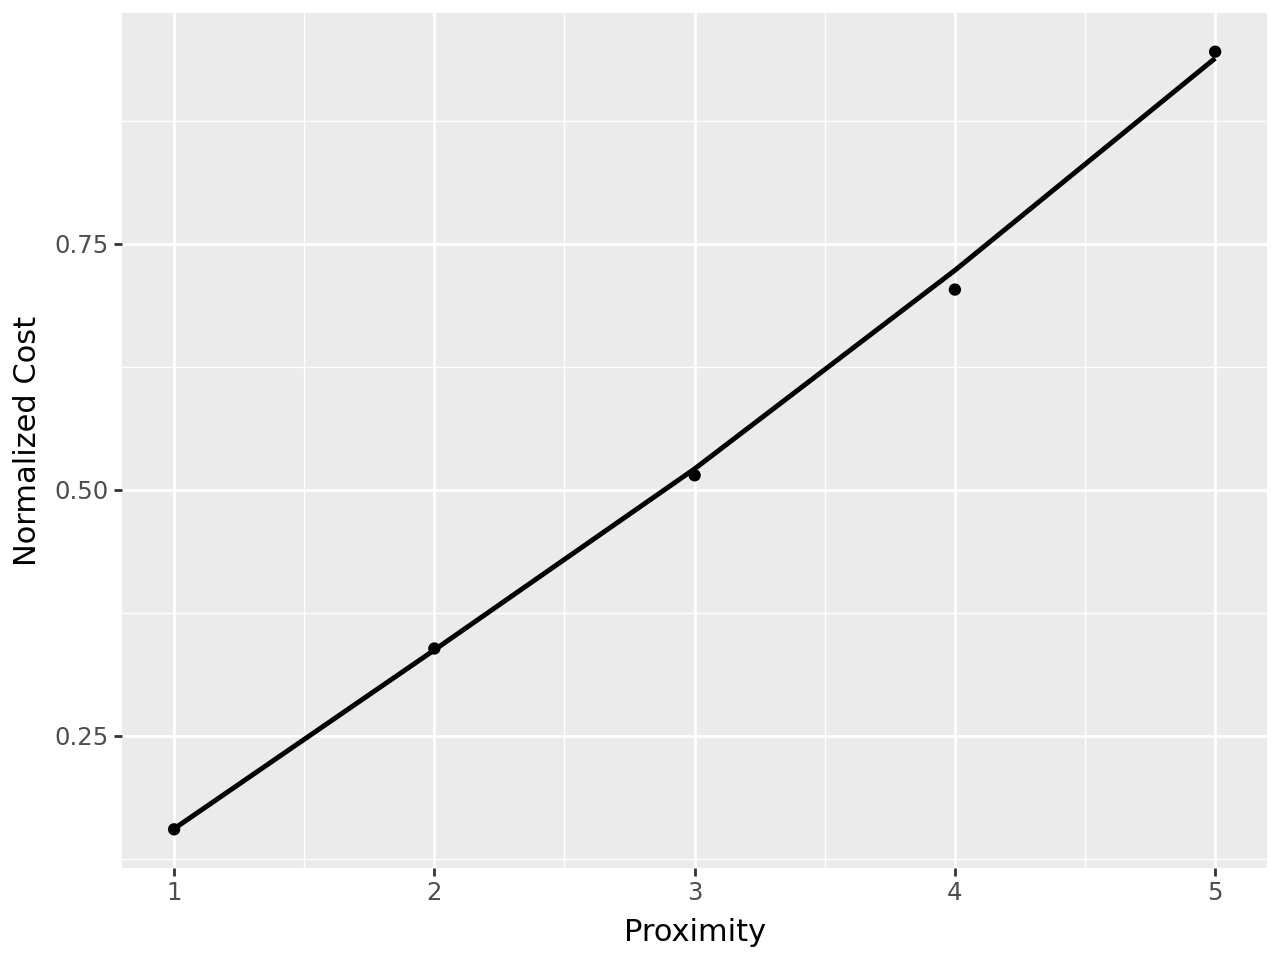

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_proximity_norm_cost.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [29]:
p = (
    ggplot(same_starts) + 
    aes(x='proximity', y='norm_cost') + 
    geom_point(data=means_per_proximity_same_starts) + 
    geom_smooth() +
    xlab("Proximity") +
    ylab("Normalized Cost")
)

p.show()
p.save("same_starts_proximity_norm_cost.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


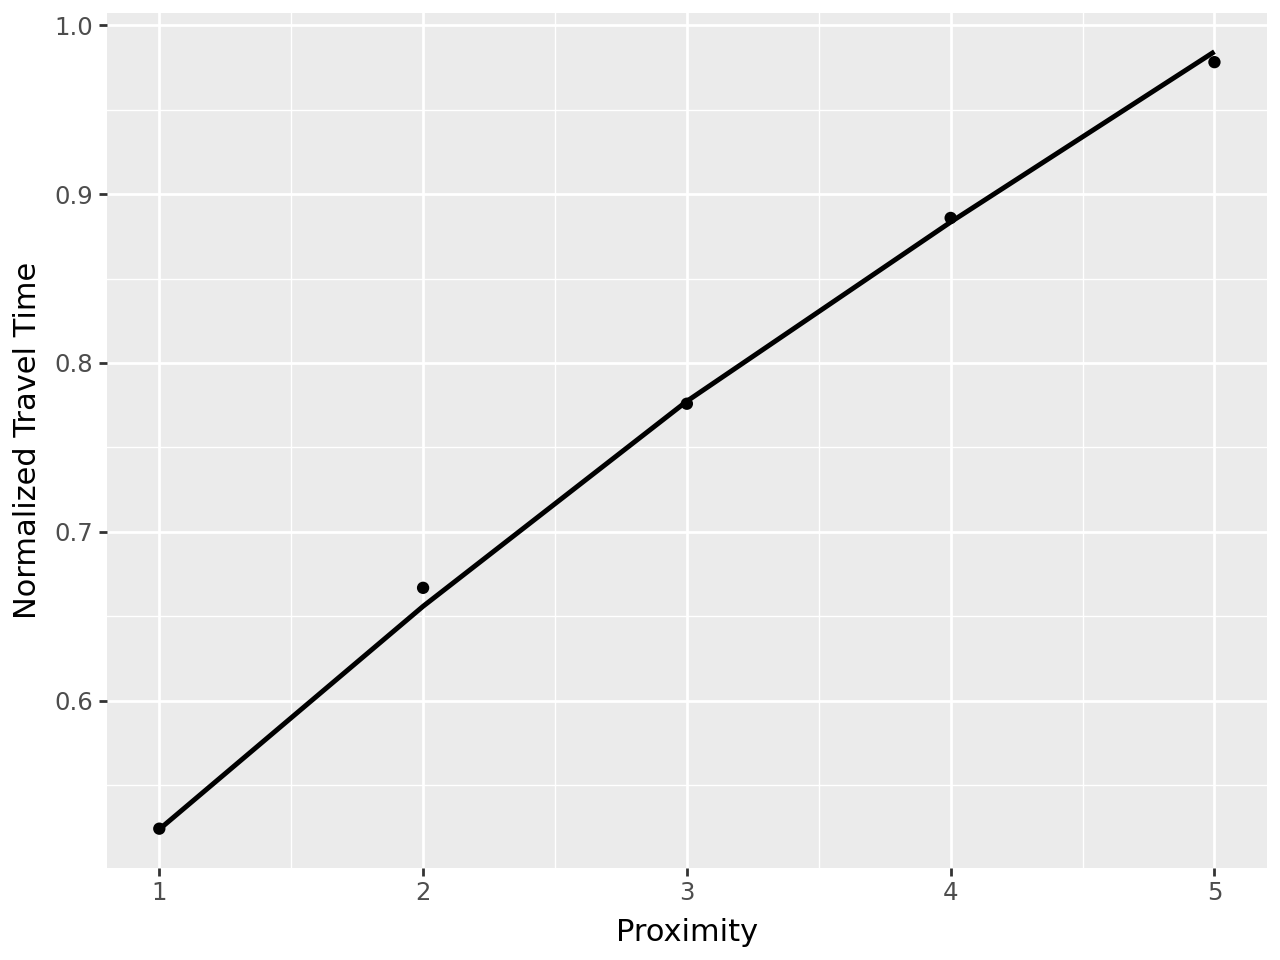

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_proximity_norm_travel_time.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [30]:
p = (
    ggplot(same_starts) + 
    aes(x='proximity', y='norm_travel_time') + 
    geom_point(data=means_per_proximity_same_starts) + 
    geom_smooth() +
    xlab("Proximity") +
    ylab("Normalized Travel Time")
)

p.show()
p.save("same_starts_proximity_norm_travel_time.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


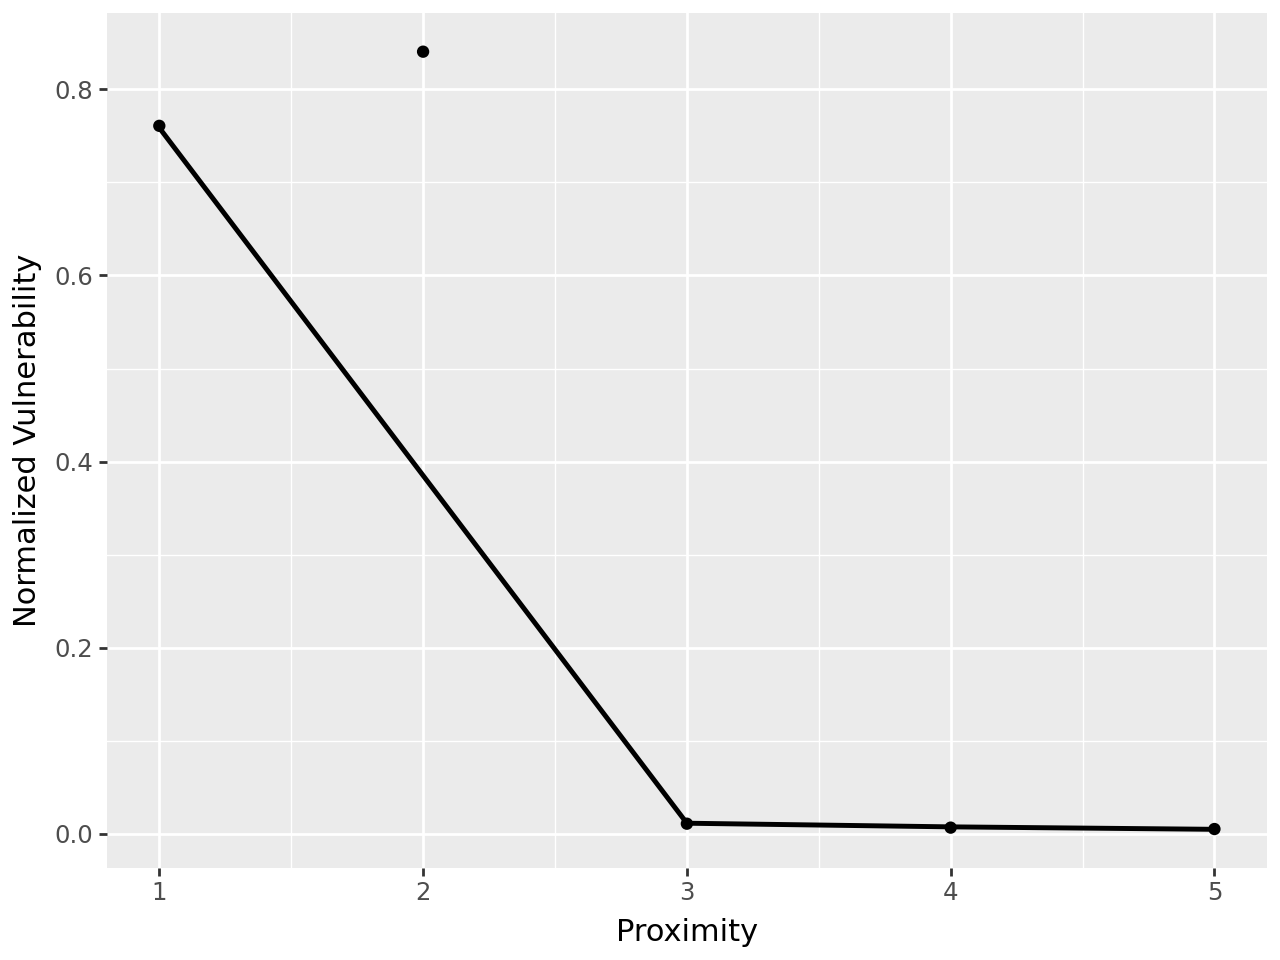

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_proximity_norm_vulnerability.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [31]:
p = (
    ggplot(same_starts) + 
    aes(x='proximity', y='norm_vulnerability') + 
    geom_point(data=means_per_proximity_same_starts) + 
    geom_smooth() +
    xlab("Proximity") +
    ylab("Normalized Vulnerability")
)

p.show()
p.save("same_starts_proximity_norm_vulnerability.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


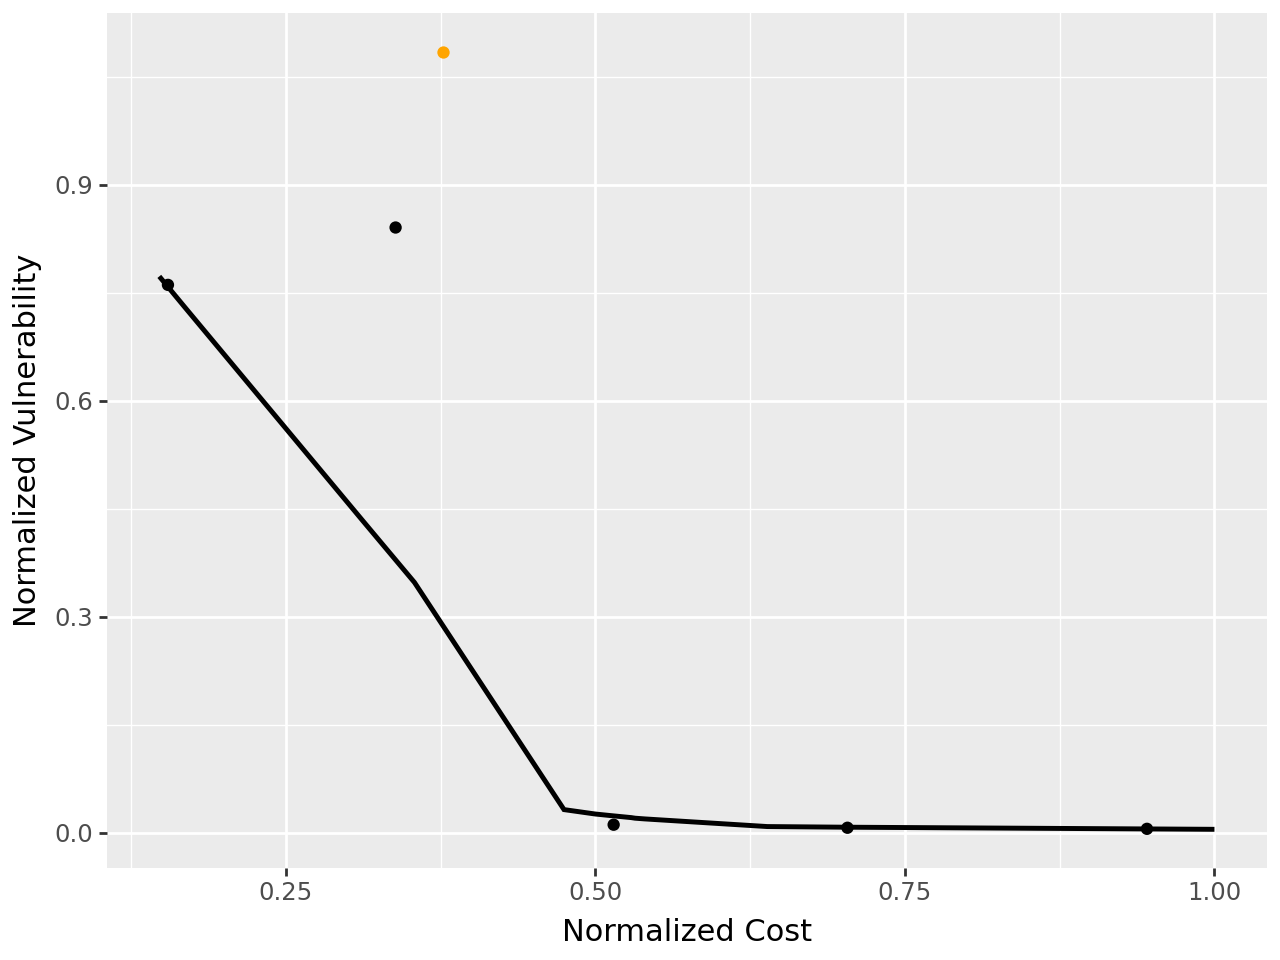

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_norm_cost_norm_vulnerability.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [32]:
p = (
    ggplot(same_starts) + 
    aes(x='norm_cost', y='norm_vulnerability') + 
    geom_point(data=means_per_proximity_same_starts) + 
    geom_smooth() +
    geom_point(data=ns_same_starts, color='orange') +
    xlab("Normalized Cost") +
    ylab("Normalized Vulnerability")
)

p.show()
p.save("same_starts_norm_cost_norm_vulnerability.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


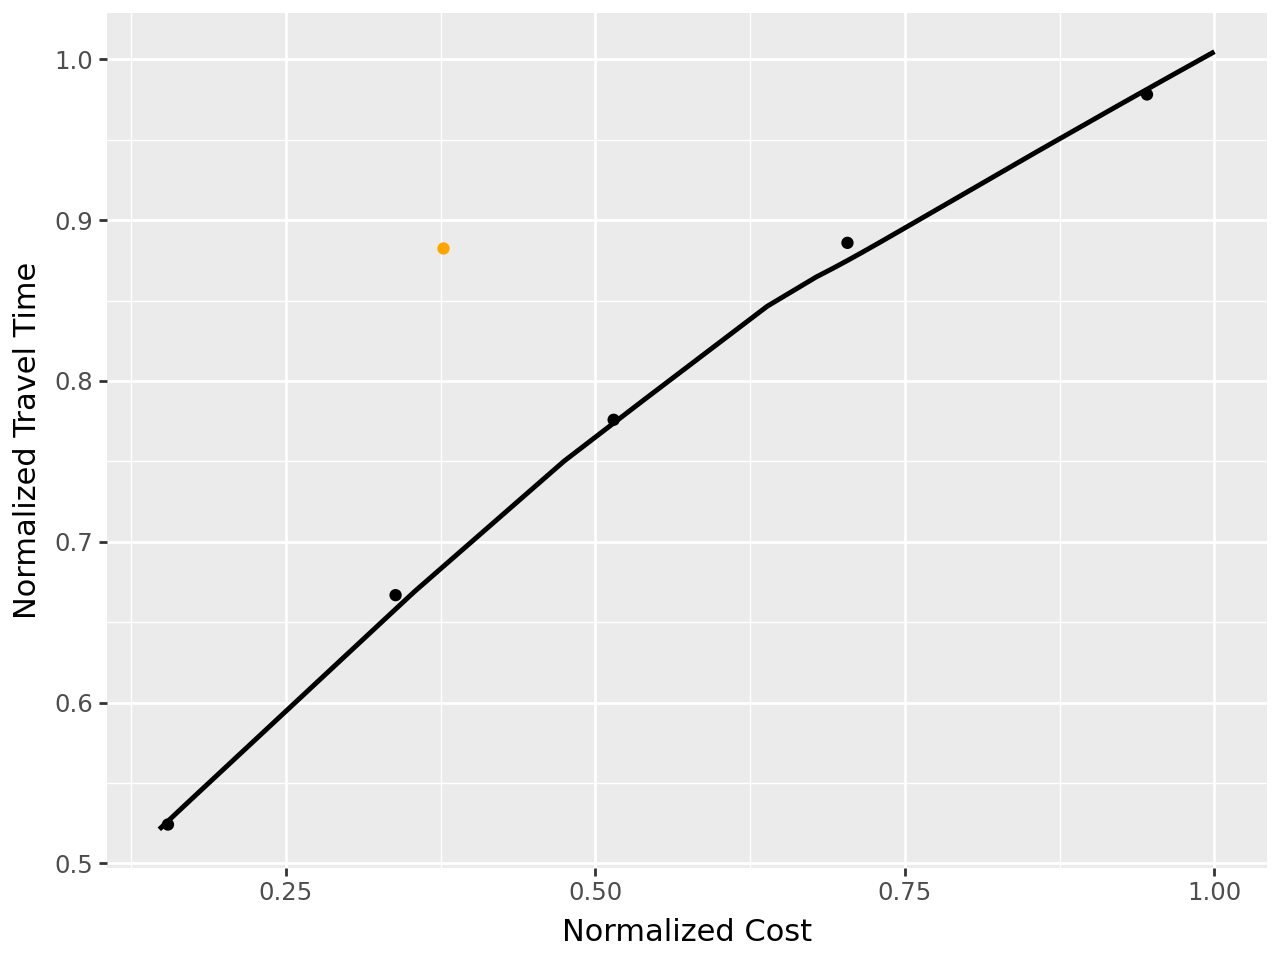

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_norm_cost_norm_travel_time.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [33]:
p = (
    ggplot(same_starts) + 
    aes(x='norm_cost', y='norm_travel_time') + 
    geom_point(data=means_per_proximity_same_starts) + 
    geom_smooth() +
    geom_point(data=ns_same_starts, color='orange') +
    xlab("Normalized Cost") +
    ylab("Normalized Travel Time")
)

p.show()
p.save("same_starts_norm_cost_norm_travel_time.png")

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


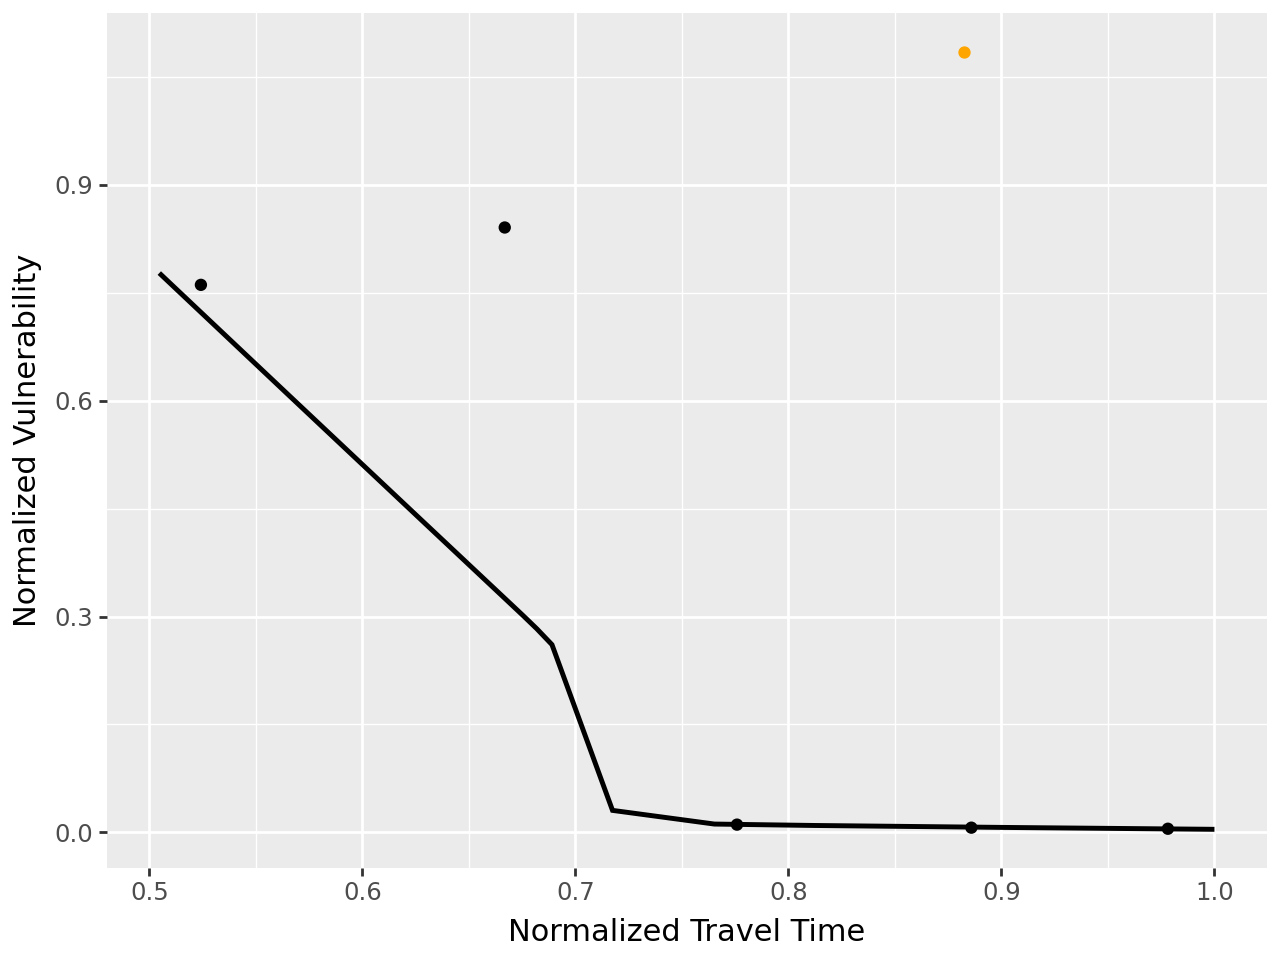

/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: same_starts_norm_travel_time_norm_vulnerability.png
/home/eelke/CC/SEM2/Natural Computing/.venv/lib64/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


In [34]:
p = (
    ggplot(same_starts) + 
    aes(x='norm_travel_time', y='norm_vulnerability') + 
    geom_point(data=means_per_proximity_same_starts) + 
    geom_smooth() +
    geom_point(data=ns_same_starts, color='orange') +
    xlab("Normalized Travel Time") +
    ylab("Normalized Vulnerability")
)

p.show()
p.save("same_starts_norm_travel_time_norm_vulnerability.png")